In [15]:
from utils.quack import Quack
import joblib
from sim_utils.modeling import create_model, update_config

In [50]:
passes = Quack.query("""

					 with sacks as (
select 
game_id,
play_id,
avg(sack) over (partition by passer_player_id, passer_player_name
						  order by game_id, play_id
						  rows between 500 preceding and current row) as sack_rolling_avg,
count(sack) over (
    partition by passer_player_id, passer_player_name
    order by game_id, play_id
    rows between 1000 preceding and current row
) as n_plays,
passer_player_id,
passer_player_name
 from pbp
where play_type = 'pass'
and season > 2020
						  ),
weighted_sack as (
select game_id,
						  play_id,
						  ((sack_rolling_avg * n_plays) + (.07 * 50) )/ (n_plays + 50) as sack_rolling_avg,
						  n_plays,
						  passer_player_id,
						  passer_player_name
from sacks
						  )
						  
select game_id, play_id, week, season, posteam, defteam, yards_gained,
    quarter_seconds_remaining,
    half_seconds_remaining,
    game_seconds_remaining,
    yardline_100,
    down,
    goal_to_go,
    ydstogo,
    score_differential,
    temp,
    spread_line,
    total_line,
    posteam_timeouts_remaining,
    qtr as quarter,
sack,
pass_attempt,
qb_dropback,
passer_player_id,
passer_player_name,
sack_rolling_avg
 from pbp join weighted_sack using (game_id, play_id, passer_player_id, passer_player_name)
where play_type = 'pass'
and season > 2020
					 """)
passes

,game_id,play_id,week,season,posteam,defteam,yards_gained,quarter_seconds_remaining,half_seconds_remaining,game_seconds_remaining,...,spread_line,total_line,posteam_timeouts_remaining,quarter,sack,pass_attempt,qb_dropback,passer_player_id,passer_player_name,sack_rolling_avg
0,2021_08_MIA_BUF,1251.0,8,2021,BUF,MIA,20.0,490.0,490.0,2290.0,...,15.0,48.5,3.0,2.0,0.0,1.0,1.0,00-0034857,J.Allen,0.045635
1,2021_08_MIA_BUF,1275.0,8,2021,BUF,MIA,3.0,458.0,458.0,2258.0,...,15.0,48.5,3.0,2.0,0.0,1.0,1.0,00-0034857,J.Allen,0.045455
2,2021_08_MIA_BUF,1299.0,8,2021,BUF,MIA,0.0,420.0,420.0,2220.0,...,15.0,48.5,3.0,2.0,0.0,1.0,1.0,00-0034857,J.Allen,0.045276
3,2021_08_MIA_BUF,1321.0,8,2021,BUF,MIA,0.0,415.0,415.0,2215.0,...,15.0,48.5,3.0,2.0,0.0,1.0,1.0,00-0034857,J.Allen,0.045098
4,2021_08_MIA_BUF,1368.0,8,2021,MIA,BUF,0.0,398.0,398.0,2198.0,...,15.0,48.5,3.0,2.0,0.0,1.0,1.0,00-0036212,T.Tagovailoa,0.050802
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96608,2023_17_LAC_DEN,899.0,17,2023,DEN,LAC,4.0,134.0,1034.0,2834.0,...,3.5,39.5,2.0,1.0,0.0,1.0,1.0,00-0035264,J.Stidham,0.070470
96609,2023_16_SEA_TEN,1225.0,16,2023,SEA,TEN,5.0,692.0,692.0,2492.0,...,-3.0,42.0,1.0,2.0,0.0,1.0,1.0,00-0030565,G.Smith,0.067966
96610,2023_16_WAS_NYJ,1126.0,16,2023,WAS,NYJ,13.0,122.0,1022.0,2822.0,...,3.0,36.5,3.0,1.0,0.0,1.0,1.0,00-0037077,S.Howell,0.088361
96611,2023_17_ATL_CHI,1858.0,17,2023,ATL,CHI,0.0,70.0,70.0,1870.0,...,3.0,39.0,2.0,2.0,0.0,1.0,1.0,00-0031800,T.Heinicke,0.075550


In [51]:
sack_x = [
    "quarter_seconds_remaining",
    "half_seconds_remaining",
    "game_seconds_remaining",
    "yardline_100",
    "down",
    "goal_to_go",
    "ydstogo",
    "score_differential",
    "temp",
    "spread_line",
    "total_line",
    "posteam_timeouts_remaining",
    "quarter",
	
]
sack_y = "sack"
sack_model = create_model(passes, sack_x, sack_y)

print("Sack model created..")
model_path = "models/oob_model.joblib"
joblib.dump(sack_model, model_path)

feature_config = {
	'sack_model':{
    "feature_cols": sack_x,
	'model_path': model_path
	}
}
update_config(feature_config)

Accuracy: 0.93
Confusion Matrix:
[[18048     5]
 [ 1270     0]]
Sack model created..


In [10]:
sacks = passes.loc[passes.sack==1].copy()


(array([  0.,   2.,   4.,   3.,   7.,   7.,   9.,  16.,  21.,  38.,  75.,
        104., 132., 112.,  90.,  75.,  68.,  53., 100.]),
 array([-20., -19., -18., -17., -16., -15., -14., -13., -12., -11., -10.,
         -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.]),
 <BarContainer object of 19 artists>)

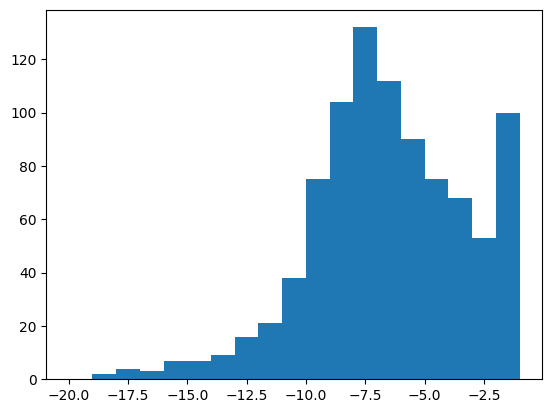

In [13]:
import matplotlib.pyplot as plt

plt.hist(sacks['yards_gained'],bins=range(-20,0))

In [9]:
passes.groupby(['passer_player_name'])['yards_gained'].mean().reset_index().sort_values(by='yards_gained')

,passer_player_name,yards_gained
17,C.Sutton,-5.00
8,B.Rypien,-2.00
54,K.Slovis,-1.00
11,C.Kmet,0.00
14,C.Olave,0.00
...,...,...
62,M.Trubisky,9.00
47,J.Milton,11.00
74,T.Bagent,11.75
10,C.Akers,32.00


In [4]:
Quack.query("""
with passes as (
select
yards_gained,
sack,
pass_attempt,
qb_dropback,
passer_player_id,
passer_player_name
 from pbp
where play_type = 'pass'
and season = 2025

)
select sum(yards_gained),
sum(case when sack = 1 then 1 else 0 end) as num_sacks,
count(*) as num_dropback,
num_sacks / num_dropback as sack_pct,
passer_player_name
from passes
group by all 
having num_dropback > 10
order by 4 desc
					 """)

,sum(yards_gained),num_sacks,num_dropback,sack_pct,passer_player_name
0,239.0,8.0,45,0.177778,A.Dalton
1,136.0,6.0,36,0.166667,B.Cook
2,223.0,6.0,42,0.142857,T.Huntley
3,78.0,2.0,14,0.142857,T.Lance
4,41.0,2.0,17,0.117647,T.Bridgewater
5,1056.0,27.0,233,0.115880,J.Fields
6,970.0,24.0,209,0.114833,J.McCarthy
7,2300.0,49.0,446,0.109865,G.Smith
8,1093.0,19.0,188,0.101064,C.Wentz
9,2097.0,49.0,486,0.100823,C.Ward
